In [1]:
import pandas as pd

titanic = pd.read_csv(
    'http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic.txt')

In [2]:
titanic.head()

,row.names,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,sex
0,1,1st,1,"Allen, Miss Elisabeth Walton",29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female
1,2,1st,0,"Allison, Miss Helen Loraine",2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female
2,3,1st,0,"Allison, Mr Hudson Joshua Creighton",30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,(135),male
3,4,1st,0,"Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)",25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female
4,5,1st,1,"Allison, Master Hudson Trevor",0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,NaN,11,male


分离数据特征与预测目标

In [3]:
y = titanic['survived']
X = titanic.drop(['row.names','name','survived'],axis=1)

In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1313 entries, 0 to 1312
Data columns (total 8 columns):
pclass       1313 non-null object
age          633 non-null float64
embarked     821 non-null object
home.dest    754 non-null object
room         77 non-null object
ticket       69 non-null object
boat         347 non-null object
sex          1313 non-null object
dtypes: float64(1), object(7)
memory usage: 82.1+ KB


### 对缺失的数据进行填充

In [10]:
X['age'].fillna(X['age'].mean(), inplace=True)
X.fillna('UNKNOWN', inplace=True)
X.head()

,pclass,age,embarked,home.dest,room,ticket,boat,sex
0,1st,29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female
1,1st,2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,UNKNOWN,UNKNOWN,female
2,1st,30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,UNKNOWN,(135),male
3,1st,25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,UNKNOWN,UNKNOWN,female
4,1st,0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,UNKNOWN,11,male


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=666)

### 类别型的特征向量化

In [12]:
from sklearn.feature_extraction import DictVectorizer

vec = DictVectorizer()

X_train = vec.fit_transform(X_train.to_dict(orient='record'))
X_test = vec.transform(X_test.to_dict(orient='record'))

可以看到，向量化以后的特征增加非常快，这是因为标量型的特征可能的值很多。

In [22]:
# vec.feature_names_

In [13]:
len(vec.feature_names_)

495

## 使用决策树

In [14]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='entropy')
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [16]:
dt.score(X_train, y_train)

0.9400406504065041

In [17]:
dt.score(X_test, y_test)

0.8693009118541033

## 使用特征选择器

In [23]:
from sklearn.feature_selection import SelectPercentile

fs = SelectPercentile(feature_selection.chi2, percentile=20)
X_train_fs = fs.fit_transform(X_train, y_train)

In [24]:
X_train_fs.toarray().shape

(984, 99)

In [25]:
dt.fit(X_train_fs, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [26]:
dt.score(X_train_fs, y_train)

0.9247967479674797

In [28]:
X_test_fs = fs.transform(X_test)

In [29]:
dt.score(X_test_fs, y_test)

0.8662613981762918

## 使用交叉验证的方法筛选特征

In [31]:
percentiles = list(range(1, 100, 2))
print(percentiles)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99]


In [33]:
from sklearn.model_selection import cross_val_score
import numpy as np

results = []

for i in percentiles:
    fs = feature_selection.SelectPercentile(
        feature_selection.chi2, percentile=i)
    X_train_fs = fs.fit_transform(X_train, y_train)
    scores = cross_val_score(dt, X_train_fs, y_train, cv=5)
    results = np.append(results, scores.mean())
results

array([0.8465368 , 0.86077098, 0.86790353, 0.86083282, 0.86488353,
       0.86184292, 0.86691404, 0.86692435, 0.86389404, 0.85878169,
       0.85572047, 0.85471037, 0.85774067, 0.84962894, 0.85875077,
       0.85472068, 0.85571016, 0.86180169, 0.85670996, 0.85574108,
       0.85876108, 0.85775098, 0.85875077, 0.85571016, 0.85572047,
       0.86180169, 0.86078128, 0.85875077, 0.85571016, 0.85874047,
       0.86078128, 0.86381159, 0.86180169, 0.85772006, 0.85773036,
       0.86384251, 0.86079159, 0.8648423 , 0.87298495, 0.86586271,
       0.86790353, 0.86891363, 0.8638322 , 0.8628221 , 0.86384251,
       0.86892393, 0.86178108, 0.86486291, 0.86688312, 0.86281179])

In [35]:
opt = np.where(results == np.max(results))[0][0]
opt

38

In [36]:
percentiles[opt]

77

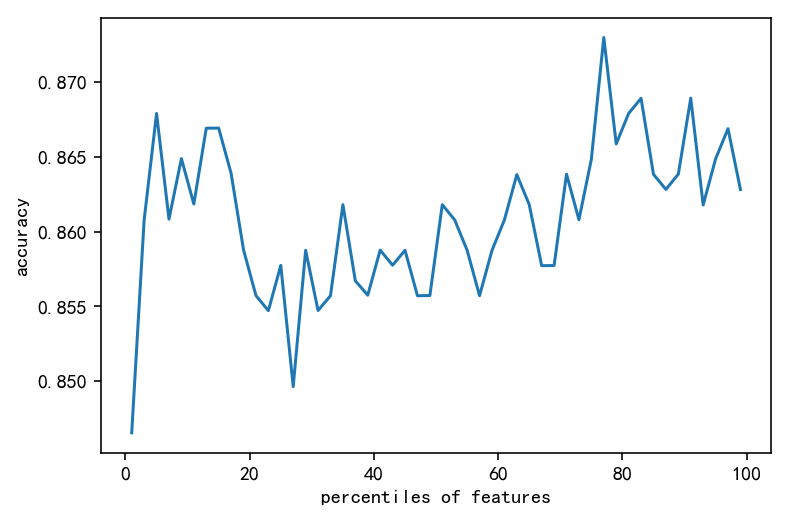

In [37]:
import matplotlib.pyplot as plt

plt.plot(percentiles, results)
plt.xlabel('percentiles of features')
plt.ylabel('accuracy')
plt.show()

In [42]:
from sklearn import feature_selection

fs = feature_selection.SelectPercentile(feature_selection.chi2, percentile=77)
X_train_fs = fs.fit_transform(X_train, y_train)
dt.fit(X_train_fs, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [43]:
X_test_fs = fs.transform(X_test)
dt.score(X_test_fs, y_test)

0.8662613981762918